In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ericanacletoribeiro/cicids2017-cleaned-and-preprocessed")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cicids2017-cleaned-and-preprocessed' dataset.
Path to dataset files: /kaggle/input/cicids2017-cleaned-and-preprocessed


In [3]:
import os

dataset_path = "/kaggle/input/cicids2017-cleaned-and-preprocessed"
print(os.listdir(dataset_path))


['cicids2017_cleaned.csv']


In [4]:
import pandas as pd

# Load CSV file
file_path = os.path.join(dataset_path, "cicids2017_cleaned.csv")
df = pd.read_csv(file_path)

# Quick look at data
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520751 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Length of Fwd Packets  int64  
 4   Fwd Packet Length Max        int64  
 5   Fwd Packet Length Min        int64  
 6   Fwd Packet Length Mean       float64
 7   Fwd Packet Length Std        float64
 8   Bwd Packet Length Max        int64  
 9   Bwd Packet Length Min        int64  
 10  Bwd Packet Length Mean       float64
 11  Bwd Packet Length Std        float64
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean                float64
 15  Flow IAT Std                 float64
 16  Flow IAT Max                 int64  
 17  Flow IAT Min                 int64  
 18  Fwd IAT Total                int64  
 19  

In [5]:
print("Number of rows and columns:", df.shape)
print("Missing values in dataset:", df.isnull().sum().sum())


Number of rows and columns: (2520751, 53)
Missing values in dataset: 0


In [7]:
print(df.columns)  # See all column names
print(df['Attack Type'].value_counts())  # Check attack types


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'Average Packet Size', 'Subflow Fwd Bytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_p

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode attack labels to numbers
label_encoder = LabelEncoder()
df['Attack Type'] = label_encoder.fit_transform(df['Attack Type'])

# Sample a smaller subset for fast training
df_sample = df.sample(n=200000, random_state=42)  # sample 200k rows

# Split features & labels
X = df_sample.drop(columns=['Attack Type'])
y = df_sample['Attack Type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.998325

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.75        24
           1       1.00      0.99      1.00       146
           2       1.00      1.00      1.00      2011
           3       1.00      1.00      1.00      3070
           4       1.00      1.00      1.00     33234
           5       0.99      0.99      0.99      1462
           6       1.00      0.94      0.97        53

    accuracy                           1.00     40000
   macro avg       0.95      0.97      0.96     40000
weighted avg       1.00      1.00      1.00     40000



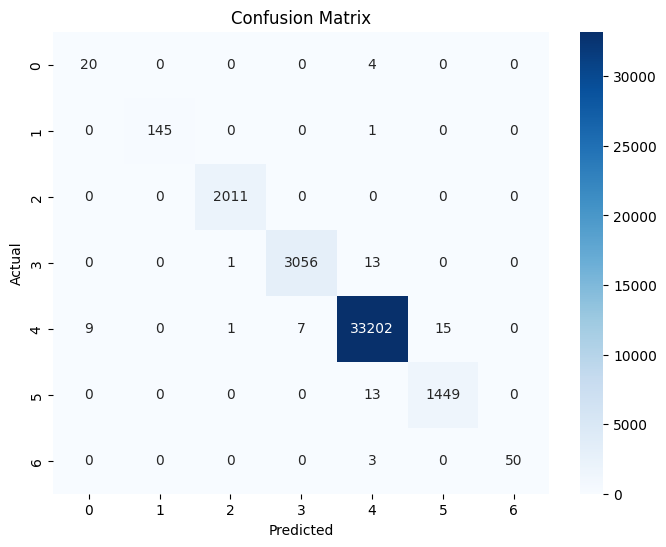

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [14]:
from sklearn.model_selection import train_test_split

# Use only 10% of training data for tuning
X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
print("Shape of tuning data:", X_small.shape)


Shape of tuning data: (16000, 52)


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,   # Try 10 random combinations
    cv=2,        # Use fewer folds for speed
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_small, y_small)

print("Best parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}


In [16]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)


In [17]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.99835

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.54      0.58        24
           1       1.00      0.99      1.00       146
           2       1.00      1.00      1.00      2011
           3       1.00      0.99      1.00      3070
           4       1.00      1.00      1.00     33234
           5       0.99      1.00      0.99      1462
           6       0.98      0.89      0.93        53

    accuracy                           1.00     40000
   macro avg       0.94      0.92      0.93     40000
weighted avg       1.00      1.00      1.00     40000



In [18]:
import joblib

# Save the model and scaler
joblib.dump(best_rf, "rf_cybersecurity_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [19]:
import time
import numpy as np

# Load the saved model
model = joblib.load("rf_cybersecurity_model.pkl")
scaler = joblib.load("scaler.pkl")

# Simulate real-time streaming
def simulate_real_time_detection(X_test, y_test, delay=0.5):
    for i in range(20):  # simulate first 20 packets
        data_point = X_test[i].reshape(1, -1)
        prediction = model.predict(data_point)[0]
        attack_type = label_encoder.inverse_transform([prediction])[0]

        print(f"🔹 Incoming Packet #{i+1}: Predicted - {attack_type}")

        # Simple automatic response
        if attack_type != "BENIGN":
            print(f"🚨 Alert! Possible Attack Detected: {attack_type}")

        time.sleep(delay)  # simulate real-time delay

simulate_real_time_detection(X_test, y_test)


🔹 Incoming Packet #1: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #2: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #3: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #4: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #5: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #6: Predicted - 3
🚨 Alert! Possible Attack Detected: 3
🔹 Incoming Packet #7: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #8: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #9: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #10: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #11: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #12: Predicted - 4
🚨 Alert! Possible Attack Detected: 4
🔹 Incoming Packet #13: Predicted - 2
🚨 Alert! Possible Attack Detected: 2
🔹 Incoming Packet #14: Predicted - 4
🚨 Alert! P

In [22]:
# ✅ STEP 1: Save trained model and scaler
import joblib

# Save the tuned model and scaler
joblib.dump(best_rf, "rf_cybersecurity_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [23]:
# ✅ STEP 2: Load model for real-time prediction
import joblib
import time
import numpy as np

# Load the saved model & scaler
model = joblib.load("rf_cybersecurity_model.pkl")
scaler = joblib.load("scaler.pkl")

# Real-time threat detection simulation
def simulate_real_time_detection(X_test, y_test, label_encoder, delay=0.5):
    print("🚀 Starting Real-Time Threat Detection Simulation...\n")
    for i in range(20):  # Simulate 20 incoming packets
        data_point = X_test[i].reshape(1, -1)
        prediction = model.predict(data_point)[0]
        attack_type = label_encoder.inverse_transform([prediction])[0]

        print(f"🔹 Packet #{i+1}: Predicted - {attack_type}")

        # Simple rule-based response
        if attack_type != "BENIGN":
            print(f"🚨 ALERT! Suspicious activity detected: {attack_type}\n")
        else:
            print("✅ Safe packet detected.\n")

        time.sleep(delay)  # Simulate time delay between packets

    print("✅ Simulation completed.")

# Run simulation
simulate_real_time_detection(X_test, y_test, label_encoder)


🚀 Starting Real-Time Threat Detection Simulation...

🔹 Packet #1: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #2: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #3: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #4: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #5: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #6: Predicted - 3
🚨 ALERT! Suspicious activity detected: 3

🔹 Packet #7: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #8: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #9: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #10: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #11: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #12: Predicted - 4
🚨 ALERT! Suspicious activity detected: 4

🔹 Packet #13: Predicted - 2
🚨 ALERT! Suspicious activity detected: 2

🔹 Packet #14: Predicted - 4
🚨 ALERT! Suspiciou

In [25]:
import smtplib

def send_email_alert(attack_type):
    try:
        sender = "bassasrilakshmi@gmail.com"
        receiver = "bassasrilakshmi@gmail.com"
        subject = f"Cyber Threat Alert: {attack_type}"
        body = f"A {attack_type} attack has been detected. Immediate action required."
        message = f"Subject:{subject}\n\n{body}"

        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender, "yweu mqvn nqhs rujk")  # Use your Google App Password here
            server.sendmail(sender, receiver, message)
        print(f"✅ Email sent successfully for attack: {attack_type}")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")


In [26]:
send_email_alert("TEST_ATTACK")


✅ Email sent successfully for attack: TEST_ATTACK
